In [146]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


In [147]:
import matplotlib.pyplot as plt

In [148]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv ("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [149]:
train.shape

(1460, 81)

# Подготавливаем данные для отбора признаков
1. Текстовые данные представим ввиде словаря, далее уникальным "словам" присвоим уникальные индексы
2. Числовые данные и данные проиндексированных словарей приведем к одному числовому диапазаону от 0 до 1

In [150]:
test.head(6)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


Определяем как признаки символьные и какие цифровые

In [151]:
sign_heads = list(train.keys())
symbol_sign_heads = []
digit_sign_heads = []

for i, sign_head in enumerate(sign_heads):
    if isinstance(train[sign_head][0], (float)) or str(train[sign_head][0]).isdigit():
        if sign_head != "Id": # не берем id как признак
            digit_sign_heads.append(sign_head)
    else:
        symbol_sign_heads.append(sign_head)

        
print("Число символьных признаков {}".format(str(len(symbol_sign_heads))))
print("Число цифровых признаков {}".format(str(len(digit_sign_heads))))

Число символьных признаков 38
Число цифровых признаков 42


Приводим цифвровые признаки к диапазону от 0 до 1

In [152]:
for i, digit_sign_head in enumerate(digit_sign_heads):
    # убираем NaN
    if digit_sign_head != "SalePrice":
        test[digit_sign_head] = test[digit_sign_head].fillna(0)
    train[digit_sign_head] = train[digit_sign_head].fillna(0)
    # object => numeric
    try:
        test[digit_sign_head] = pd.to_numeric(test[digit_sign_head])
        train[digit_sign_head] = pd.to_numeric(train[digit_sign_head])
    except:
        # невалидный (не приводимый тип данных)
        digit_sign_heads.remove(digit_sign_head)
        continue
        
    if digit_sign_head != "SalePrice":
        local_max = max(max(train[digit_sign_head]), max(test[digit_sign_head]))
        local_min = min(min(train[digit_sign_head]), min(test[digit_sign_head]))
        train[digit_sign_head] = (train[digit_sign_head] - local_min)/(local_max - local_min)
        test[digit_sign_head] = (test[digit_sign_head] - local_min)/(local_max - local_min)


Приводим символьные списки к цифровым и приводим к диапазону от 0 до 1

In [153]:
from collections import Counter

for i, symbol_sign_head in enumerate(symbol_sign_heads): # итерируем символьные признаки
    # убираем NaN
    train[symbol_sign_head] = train[symbol_sign_head].fillna("0")
    
    # словарь 
    local_dictionary = list(Counter(test[symbol_sign_head]))
    
    for j, _dict in enumerate(local_dictionary): # итерируем словарь
        for k, item in enumerate(train[symbol_sign_head]): # итерируем символьный признак
            if item == _dict:
                train[symbol_sign_head][k] = j
    
    # object => numeric
    try:
        test[symbol_sign_head] = pd.to_numeric(test[symbol_sign_head])
        train[symbol_sign_head] = pd.to_numeric(train[symbol_sign_head])
    except:
        # невалидный (не приводимый тип данных)
        symbol_sign_heads.remove(symbol_sign_head)
        continue
    
    local_max = max(max(train[symbol_sign_head]), max(test[symbol_sign_head]))
    local_min = min(min(train[symbol_sign_head]), min(test[symbol_sign_head]))
    train[symbol_sign_head] = (train[symbol_sign_head] - local_min)/(local_max - local_min)
    test[symbol_sign_head] = (test[symbol_sign_head] - local_min)/(local_max - local_min)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [154]:
print("Итого потенциальных признаков {} ({} числовых + {} символьных)".format(str(len(symbol_sign_heads)+len(digit_sign_heads)), str(len(digit_sign_heads)), str(len(symbol_sign_heads))))
print("Остальные не провалидировались 🤷🏻")

Итого потенциальных признаков 56 (37 числовых + 19 символьных)
Остальные не провалидировались 🤷🏻


# Для отобра признаков, будем опираться на следующую гипотезы:
1) Признаки имеющие наиболее высокую коинтеграцию с массивом(мат. рядом) цен.  
2) Признаки с высокой корреляцией к цене.   
Остальными признаками стоит принебречь.  

In [155]:
all_signs = [*digit_sign_heads, *symbol_sign_heads]

results1 = []

for i, sign_head in enumerate(all_signs):
    train[sign_head] = pd.to_numeric(train[sign_head], errors='coerce').fillna(0, downcast='infer')
    res = np.corrcoef(train[sign_head], train["SalePrice"])
    if res[0][1]:
        if res[0][1] > 0.7:
            item = {sign_head: res[0][1]}
            results1.append(item)

print(results1)

[{'OverallQual': 0.7909816005838052}, {'GrLivArea': 0.708624477612652}]


/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [156]:
#train = train.drop(train[train['SalePrice'] > np.percentile(list(train['SalePrice']), 95)].index)
#train = train.drop(train[train['SalePrice'] < np.percentile(list(train['SalePrice']), 5)].index) 

In [157]:
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

results2 = []
selected_signs = []

for i, sign_head in enumerate(all_signs):
    try:
        score, pvalue, crit = sm.tsa.stattools.coint(train[sign_head], train["SalePrice"])
        if pvalue > 0 :
            item = {sign_head: pvalue}
            selected_signs.append(sign_head)
            results2.append(item)
    except:
        continue

print(results2)

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  CollinearityWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  CollinearityWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  CollinearityWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  C

[{'LotArea': 6.497809415661874e-09}, {'GrLivArea': 1.532348214287887e-26}]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  CollinearityWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  CollinearityWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  CollinearityWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  CollinearityWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not r

Опытным путем, пришел к тому, что признаки отобранные на основе корреляции показали оценку на сабмишине от 0.8 до 0.54, поэтому от второй гипотезы мы отказываемся. 
Первая гипотеза показала оценку ~0.29, попробуем улучшить оценку за счет отсечения перцентилий из df

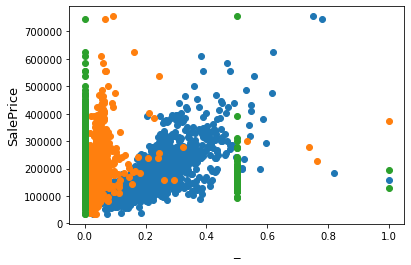

In [158]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
ax.scatter(train['LotArea'], train['SalePrice'])
ax.scatter(train['BsmtHalfBath'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('_', fontsize=13)
plt.show()

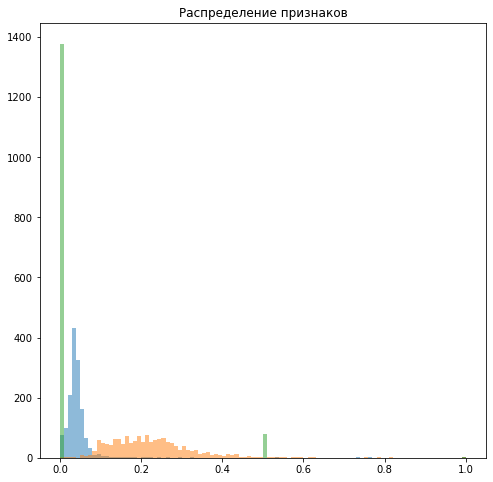

In [159]:
plt.figure(figsize= (8,8))
plt.hist(train['LotArea'], bins = 100, label = 'train', alpha = 0.5)
plt.hist(train['GrLivArea'], bins = 100, label = 'test', alpha = 0.5)
plt.hist(train['BsmtHalfBath'], bins = 100, label = 'test', alpha = 0.5)
plt.title('Распределение признаков')
plt.show()

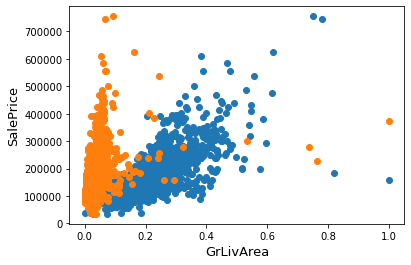

In [160]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
ax.scatter(train['LotArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# Начинаем обучение на отобранных и предобработанных признаках.


In [161]:
from sklearn.linear_model import SGDRegressor

In [162]:
from sklearn.model_selection import KFold

In [163]:
train = train.reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(train)

5

In [164]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error


In [165]:
print(kf)
model = SGDRegressor()
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    X_train, X_test = train.loc[train_index, selected_signs], train.loc[test_index, selected_signs]
    y_train, y_test = train.loc[train_index, 'SalePrice'], train.loc[test_index, 'SalePrice']

    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=5, random_state=None, shuffle=False)
Mean rmse for 5-fold: 55865.16690888485
std rmse for 5-fold: 5416.809285793136


In [166]:
model.coef_

array([126149.28013673, 562248.44973329])

In [167]:
model.intercept_

array([51453.50606694])

In [168]:
sample_submition = model.predict(test[selected_signs])

In [172]:
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [171]:
sample_submission.to_csv('submission_start.csv', index = None)